In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import scvelo as scv
import scipy as sp

import random

In [2]:
adata = ad.read('../data/processed/mus_musculus_preprocessed.h5ad')

In [3]:
list(adata.var.columns)

['Accession',
 'Chromosome',
 'End',
 'Start',
 'Strand',
 'sum_allele_c57',
 'sum_allele_cast',
 'sum_ratio_allele_c57',
 'sum_ratio_allele_cast',
 'ratio_sum_allele_c57',
 'ratio_sum_allele_cast',
 'ratio_mean_allele_c57',
 'ratio_mean_allele_cast',
 'ratio_std_allele_c57',
 'ratio_std_allele_cast',
 'allele_p_value',
 'gene_name',
 'chromosome',
 'autosomes',
 'nuclear',
 'Ribosomal_prot']

In [4]:
adata

AnnData object with n_obs × n_vars = 682 × 7439
    obs: 'plate', 'leiden', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'sum_allele_c57', 'sum_allele_cast', 'sum_ratio_allele_c57', 'sum_ratio_allele_cast', 'ratio_sum_allele_c57', 'ratio_sum_allele_cast', 'ratio_mean_allele_c57', 'ratio_mean_allele_cast', 'ratio_std_allele_c57', 'ratio_std_allele_cast', 'allele_p_value', 'gene_name', 'chromosome', 'autosomes', 'nuclear', 'Ribosomal_prot'
    uns: 'leiden', 'neighbors', 'umap'
    obsm: 'X_umap'
    layers: 'allele_c57', 'allele_cast', 'ambiguous', 'matrix', 'ratio_allele_c57', 'ratio_allele_cast', 'spanning', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [5]:
classes = [
    'bi_allelic', #class 0 : KS >=0.00000005 and std >0.1 and <=0.4
    'parent_of_origin', #class 1: KS <0.00000005 and ratio < 0.1 and ratio >0.9,
    'biased_expression', #class 2: KS < 0.00000005 and std <=0.4,
    'transcriptional bursting and aRME', #class 3: KS <0.00000005 and 0.1 < ratio < 0.9) + (KS >=0.00000005 and std > 0.4
    'zero_inflated', #class 4: remaining genes, most likely to have low count sums across both alleles
]

In [6]:
# group_1 and group _2 are primary division based on KS value threshold of 0.005
group_1 = adata.var[adata.var.allele_p_value >= 0.05]
group_2  = adata.var[adata.var.allele_p_value < 0.05]

In [7]:
bi_allelic = group_1[(group_1.ratio_std_allele_c57 >= 0.1) & (group_1.ratio_std_allele_c57 <= 0.4)]
bi_allelic_index = bi_allelic.index
len(bi_allelic_index)

2663

In [8]:
parent_of_origin = group_2[ (group_2.sum_ratio_allele_c57 <= 0.1) | 
                            (group_2.sum_ratio_allele_c57 >= 0.9) | 
                            (group_2.sum_ratio_allele_cast <= 0.1) | 
                            (group_2.sum_ratio_allele_cast >= 0.9) ]
parent_of_origin_index = parent_of_origin.index
len(parent_of_origin_index)

20

In [9]:
other_1_index = set([x for x in list(group_1.index) if x not in list(bi_allelic_index)])
other_2_index = set([x for x in list(group_2.index) if x not in list(parent_of_origin)])
other_index = other_1_index.union(other_2_index)
other = adata.var[adata.var.index.isin(other_index)]
len(other)

4776

In [10]:
biased = other[(other.allele_p_value < 0.0005) & (other.ratio_std_allele_c57 <= 0.4)]
biased_index = biased.index
len(biased_index)

1721

In [11]:
other_index = set([x for x in list(other_index) if x not in list(biased_index)])
other = adata.var[adata.var.index.isin(other_index)]
len(other_index)

3055

In [12]:
tb_arme_1 = other[ (other.allele_p_value < 0.05) &
                   (
                   ( (other.sum_ratio_allele_c57 > 0.1) & (other.sum_ratio_allele_c57 < 0.9) ) | 
                   ( (other.sum_ratio_allele_cast > 0.1) & (other.sum_ratio_allele_cast < 0.9) )
                   ) 
                 ]
tb_arme_2 = other[ (other.allele_p_value >= 0.05) & 
                   ( (other.ratio_std_allele_c57 > 0.4) & (other.ratio_std_allele_c57 < 0.7) )
                 ]
tb_arme = pd.concat([tb_arme_1, tb_arme_2])
tb_arme_index = tb_arme.index
len(tb_arme_index)

3040

In [13]:
zero_inflated_index = [x for x in list(other_index) if x not in list(tb_arme_index)]
zero_inflated = adata.var[adata.var.index.isin(zero_inflated_index)]
len(zero_inflated_index)

15

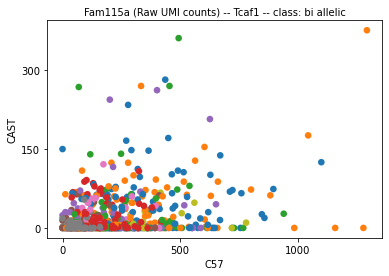

In [19]:
x = bi_allelic_index[random.randint(0,len(bi_allelic_index) - 1)]
scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: bi_allelic")

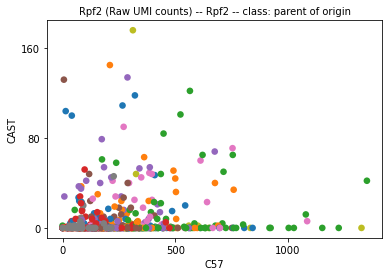

In [25]:
x = parent_of_origin_index[random.randint(0,len(parent_of_origin_index) - 1)]
scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: parent_of_origin")

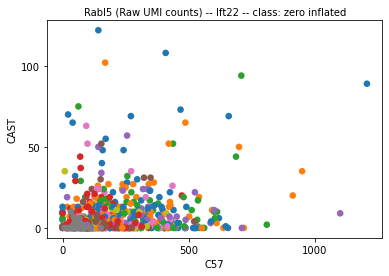

In [23]:
x = zero_inflated_index[random.randint(0,len(zero_inflated_index) - 1)]
scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: zero_inflated")

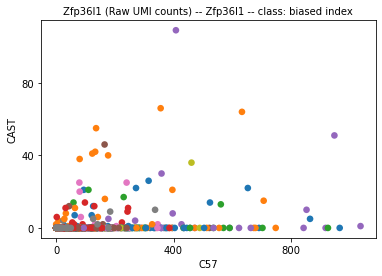

In [17]:
x = biased_index[random.randint(0,len(biased_index) - 1)]
scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: biased_index")

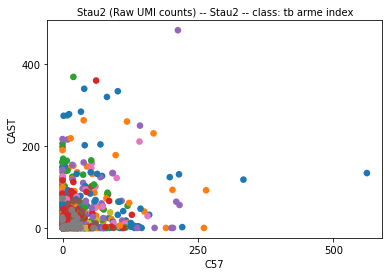

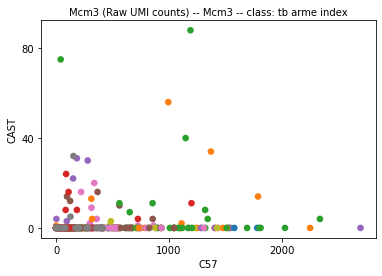

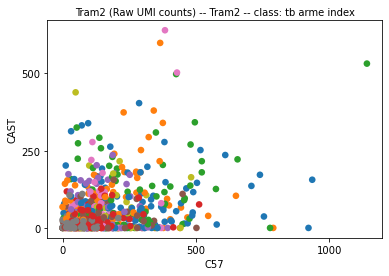

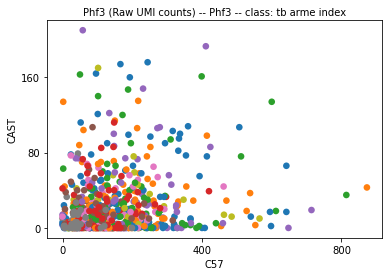

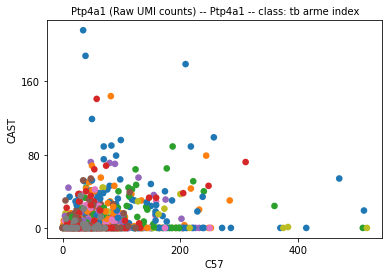

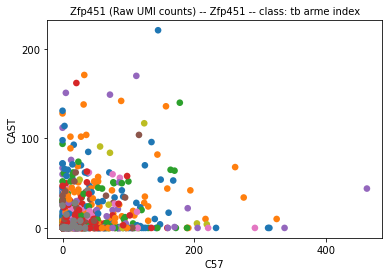

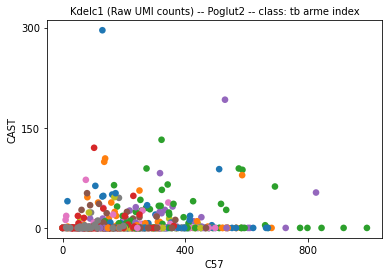

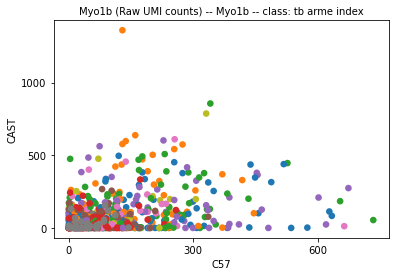

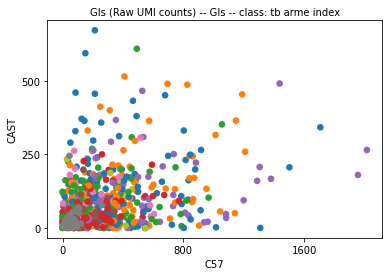

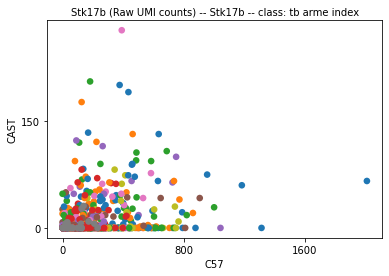

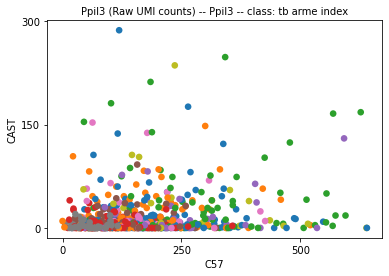

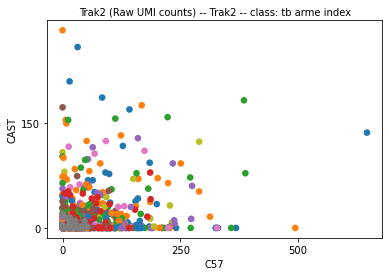

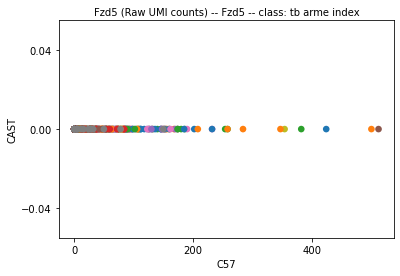

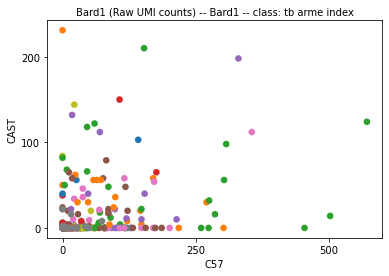

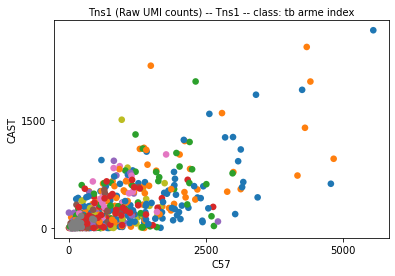

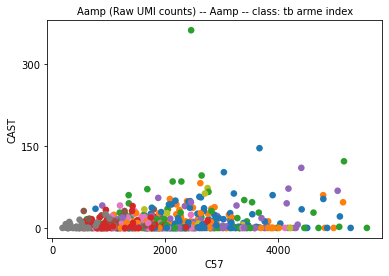

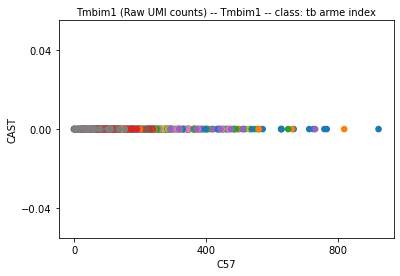

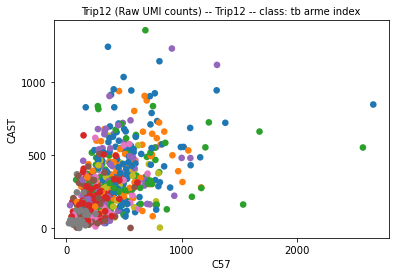

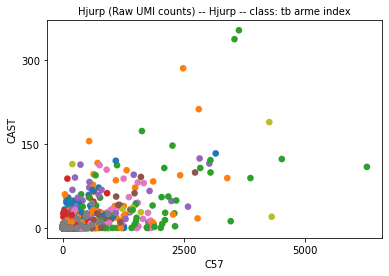

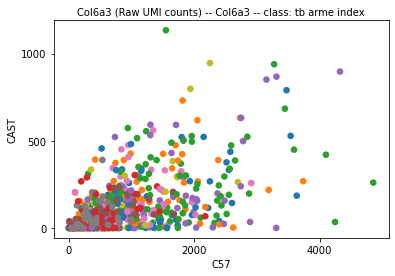

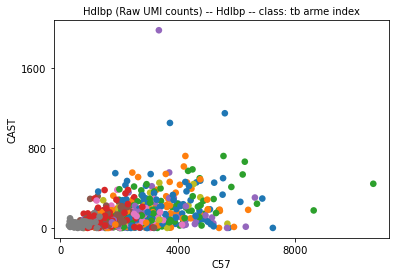

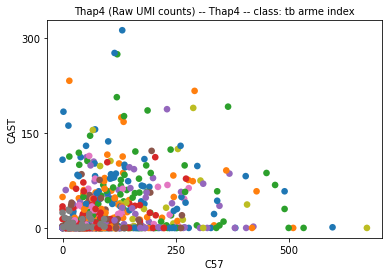

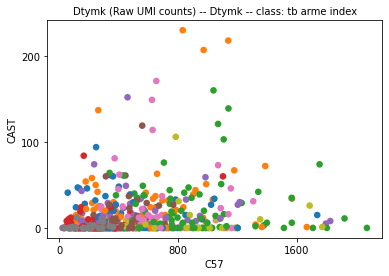

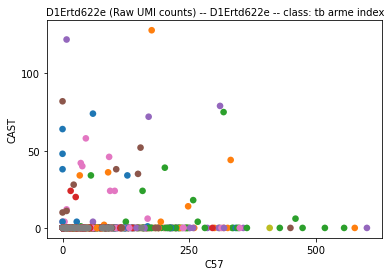

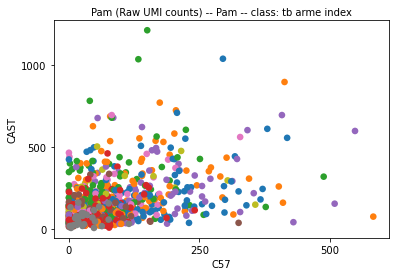

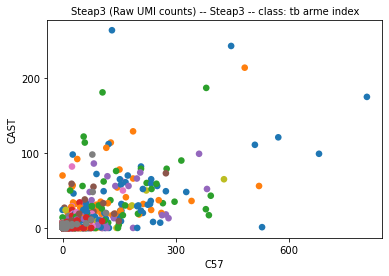

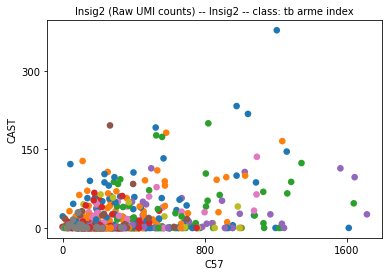

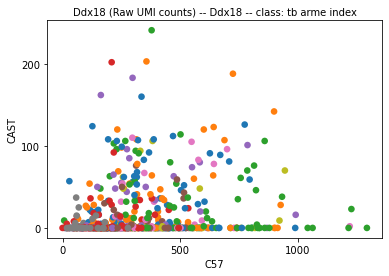

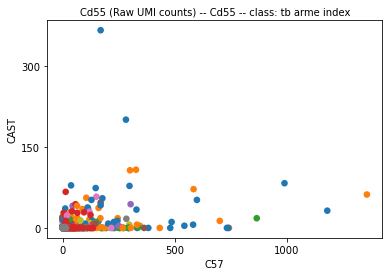

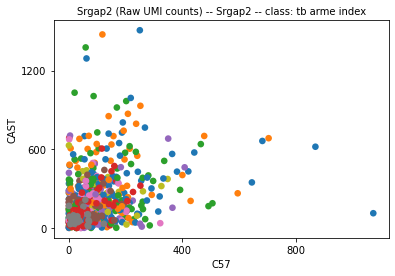

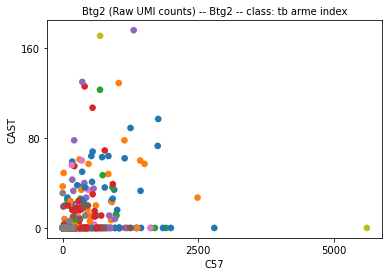

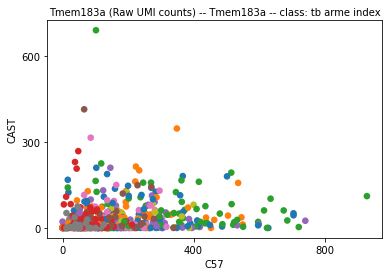

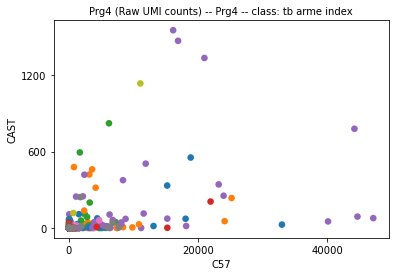

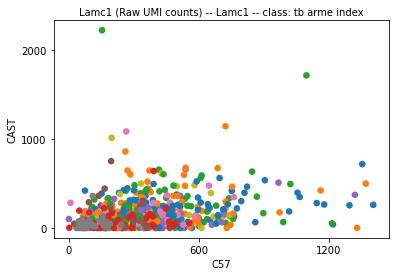

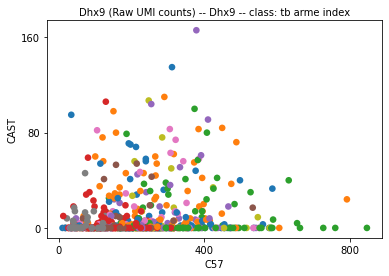

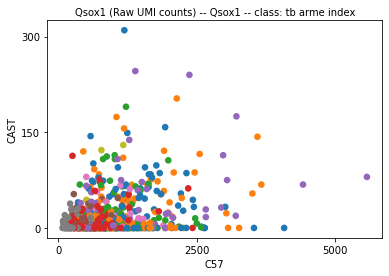

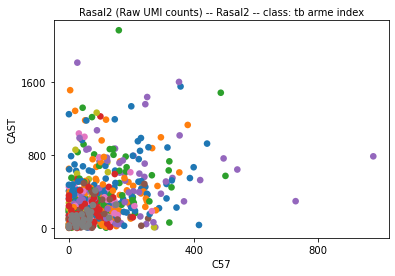

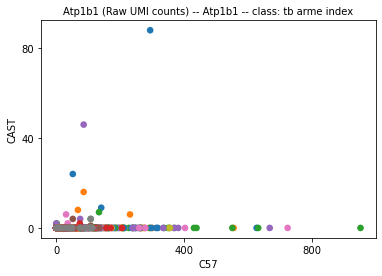

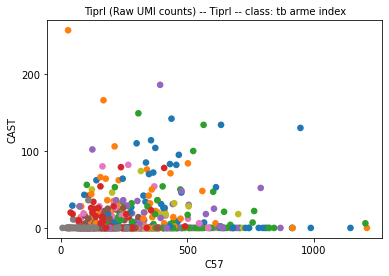

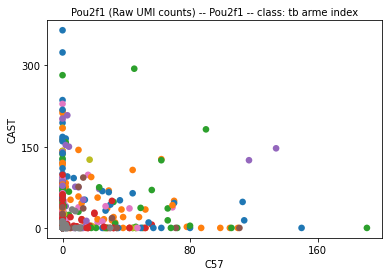

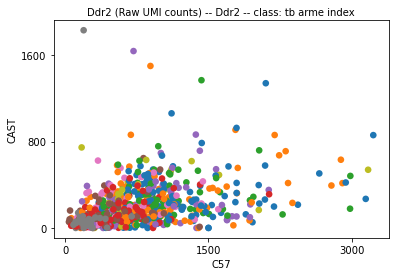

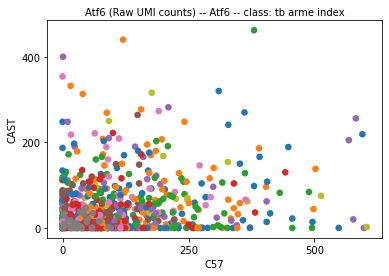

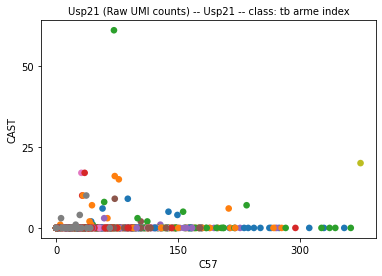

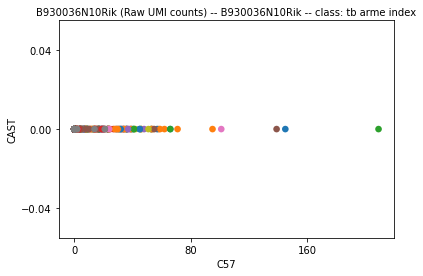

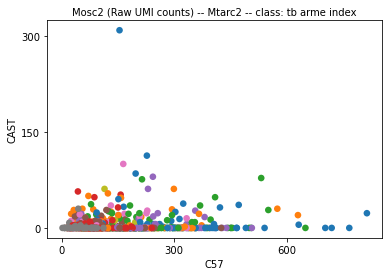

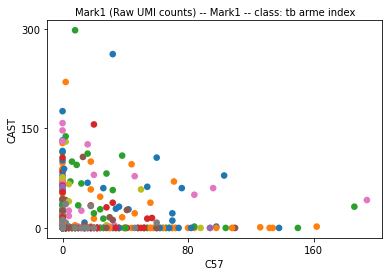

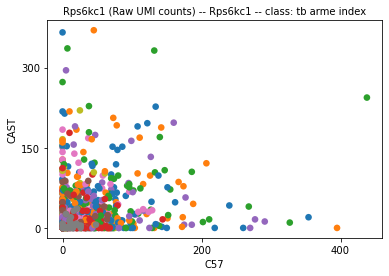

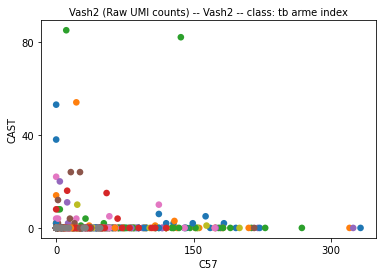

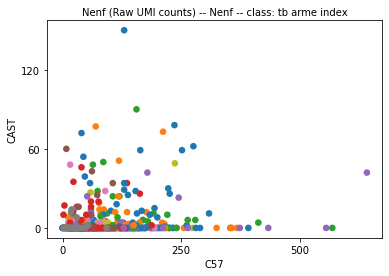

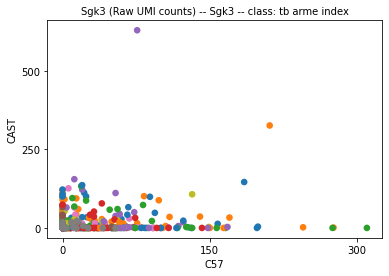

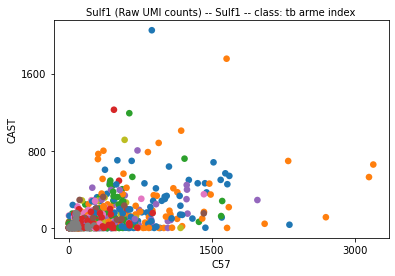

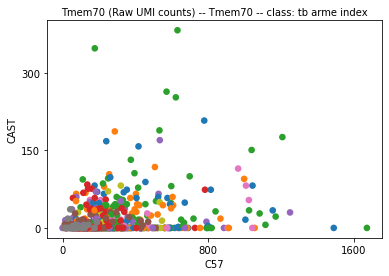

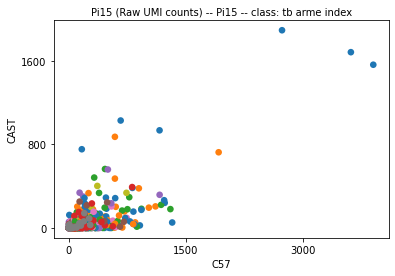

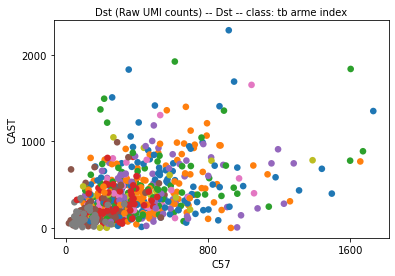

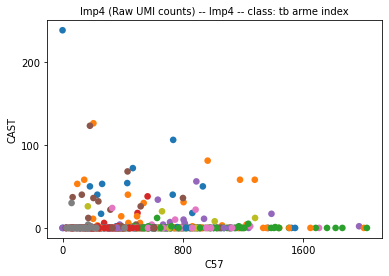

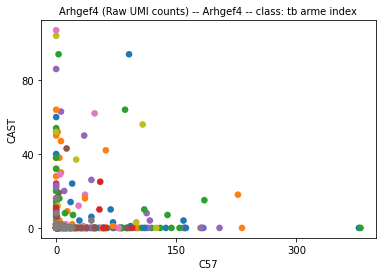

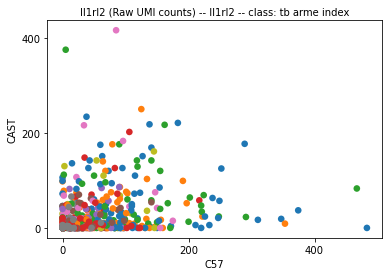

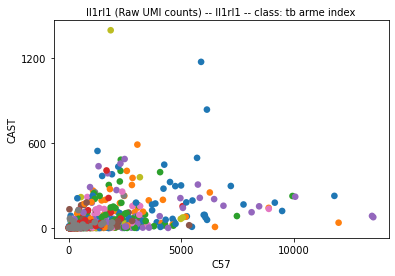

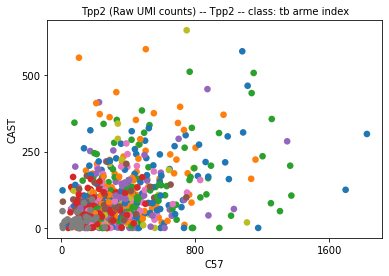

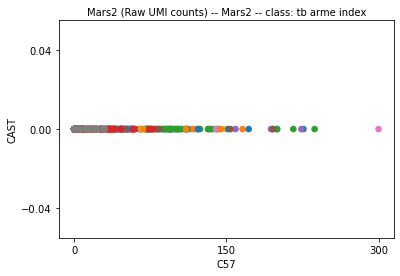

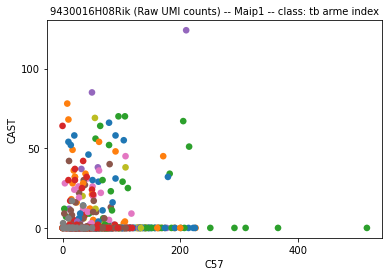

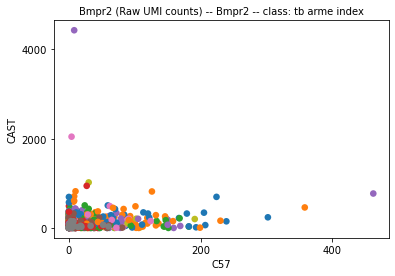

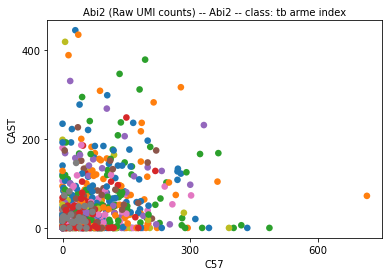

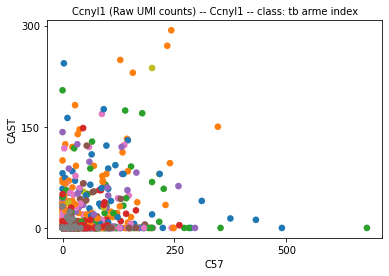

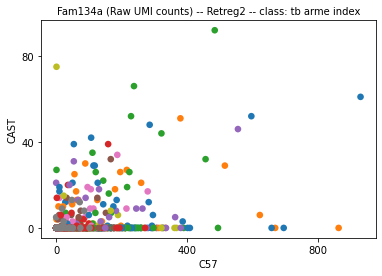

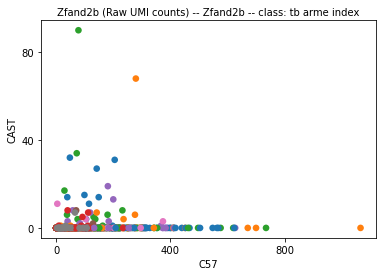

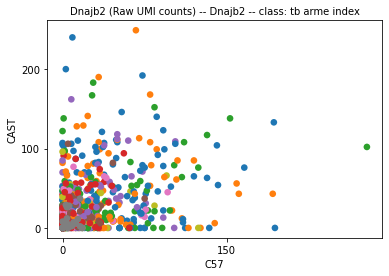

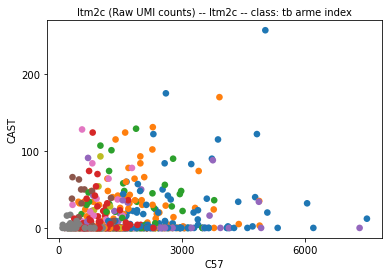

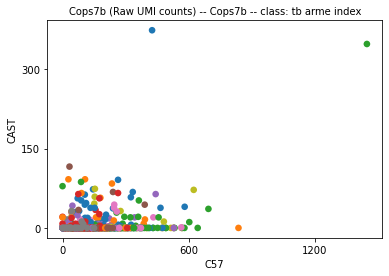

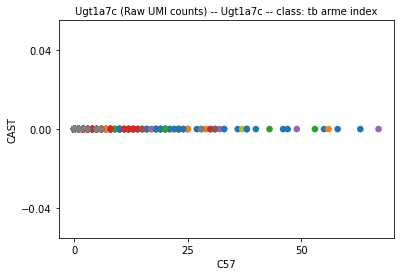

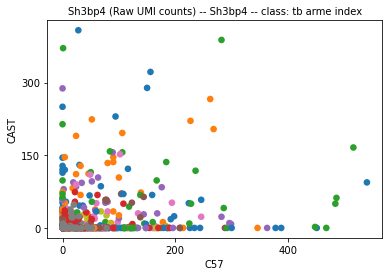

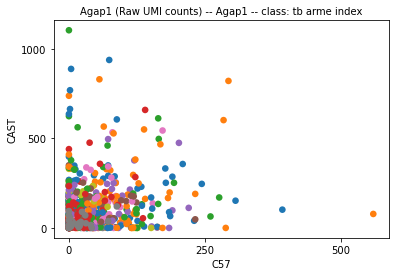

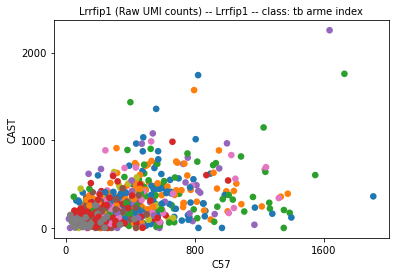

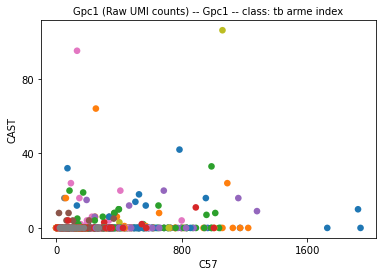

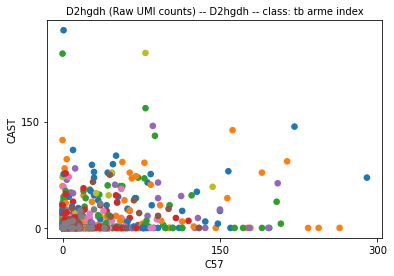

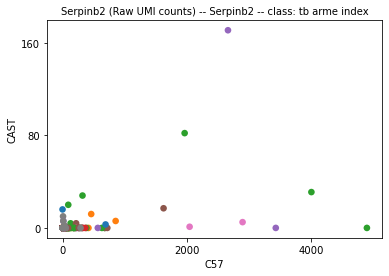

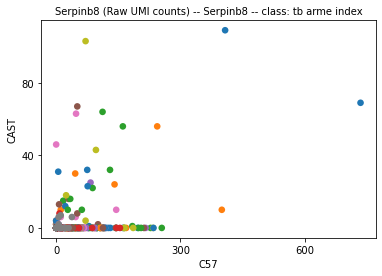

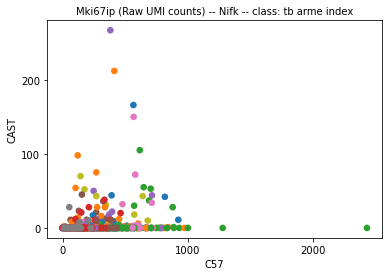

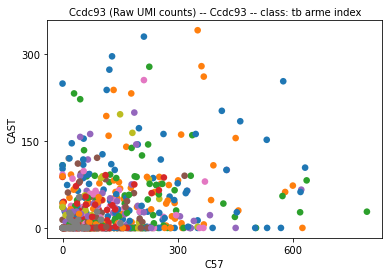

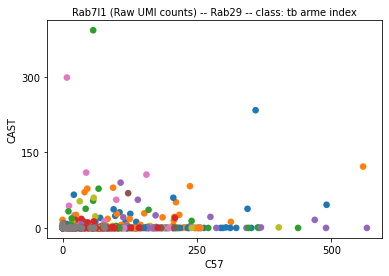

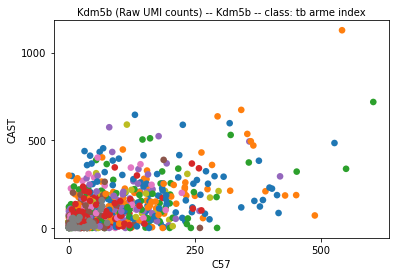

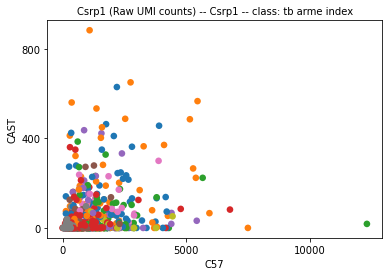

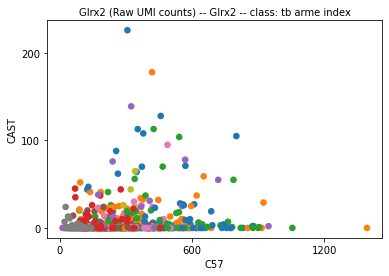

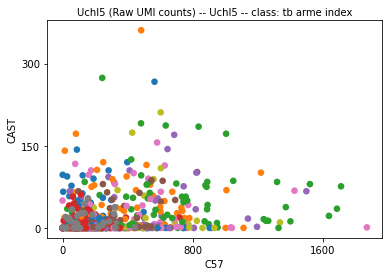

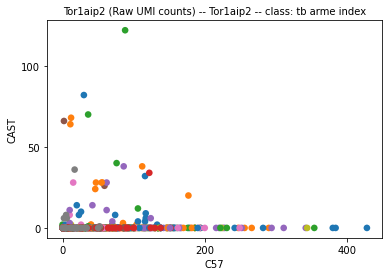

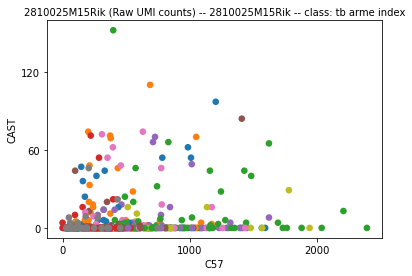

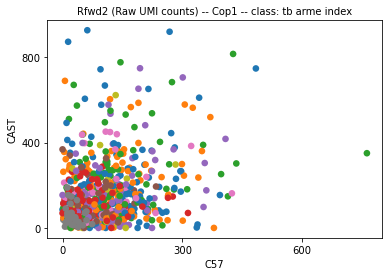

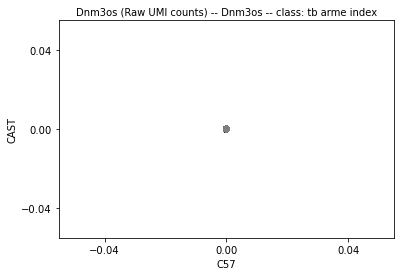

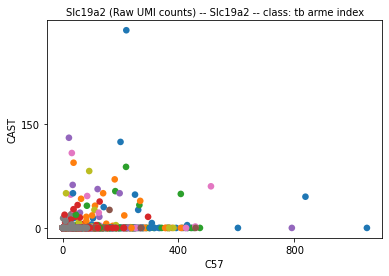

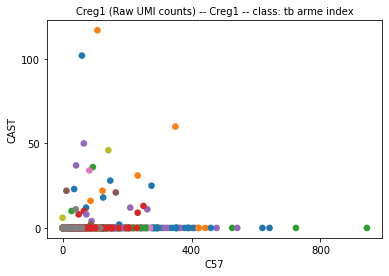

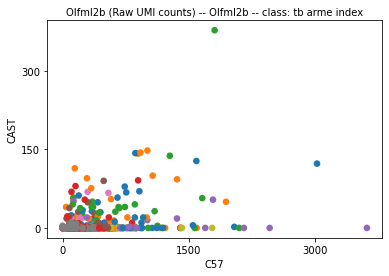

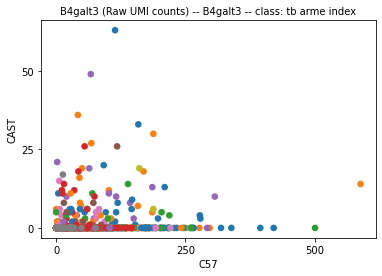

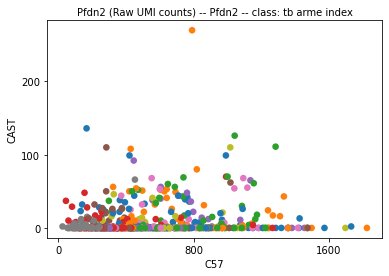

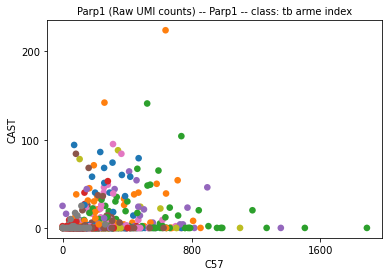

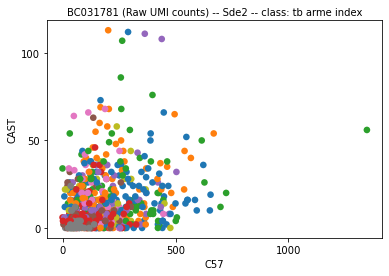

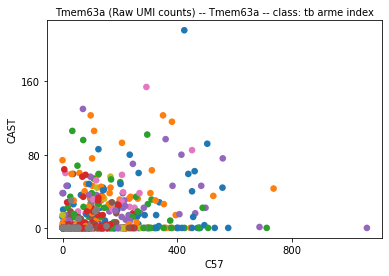

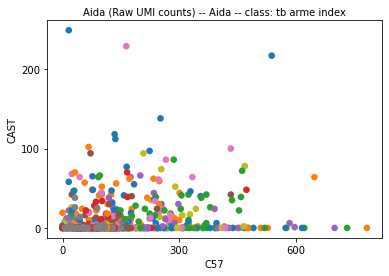

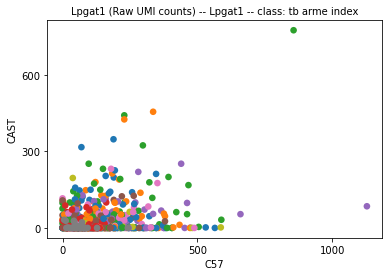

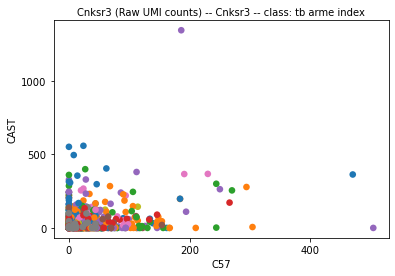

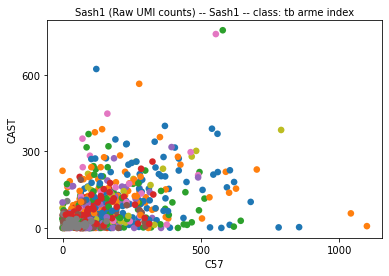

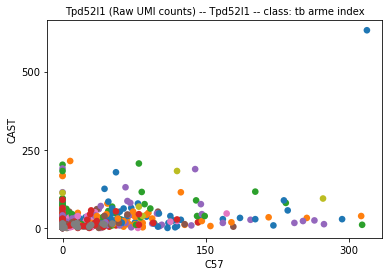

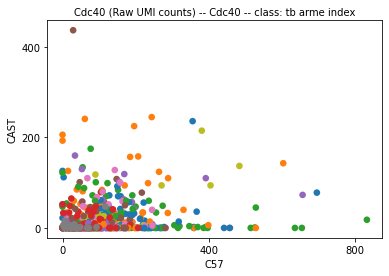

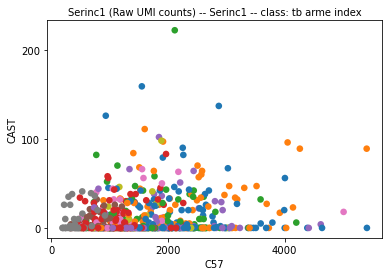

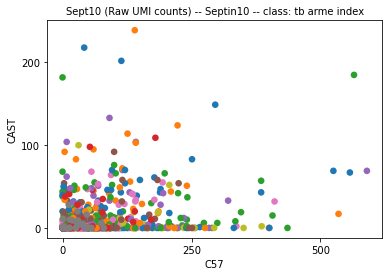

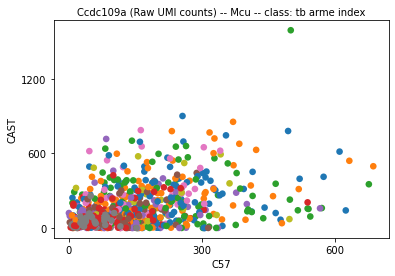

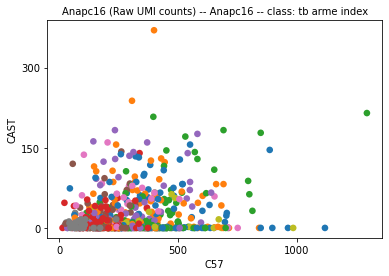

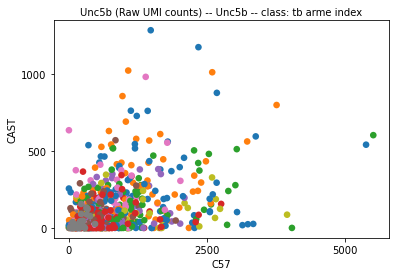

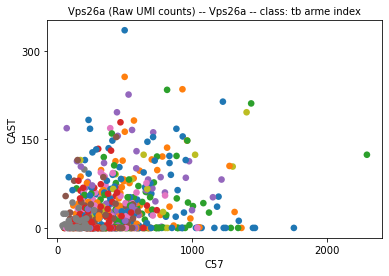

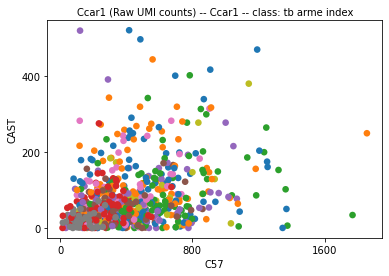

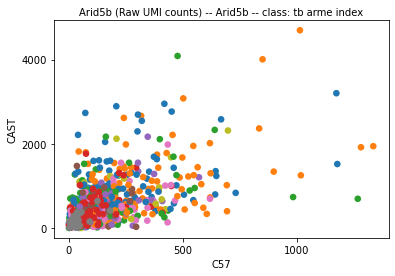

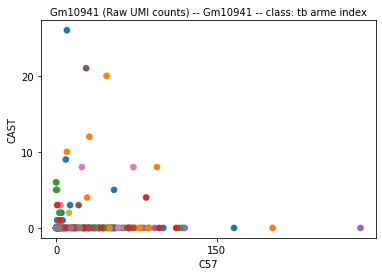

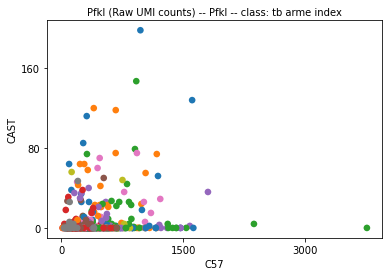

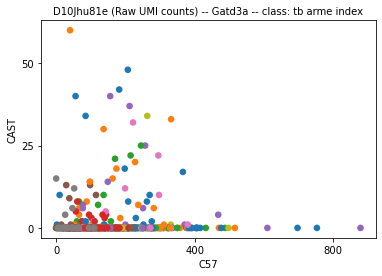

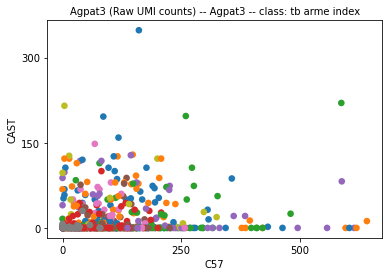

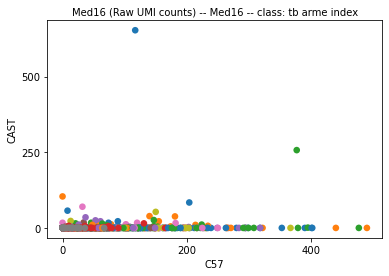

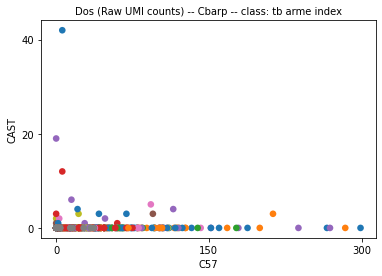

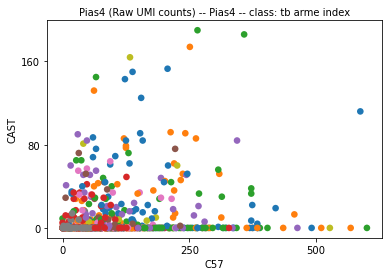

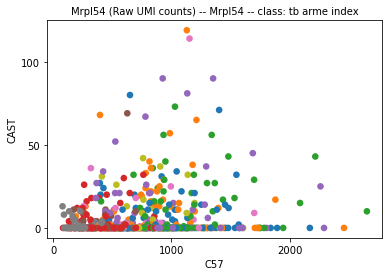

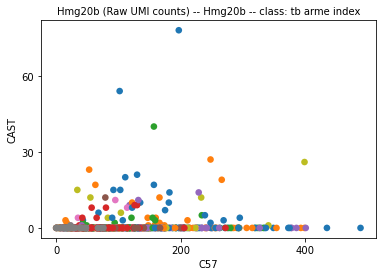

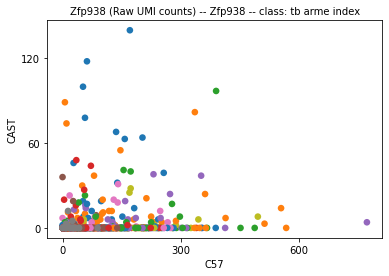

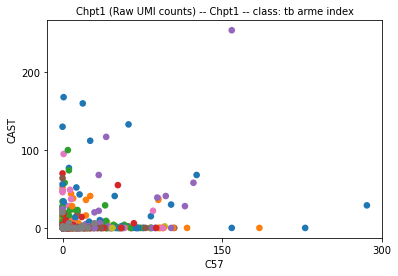

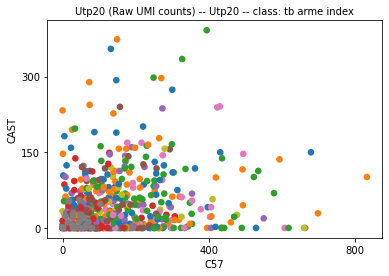

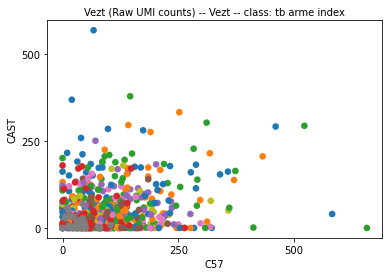

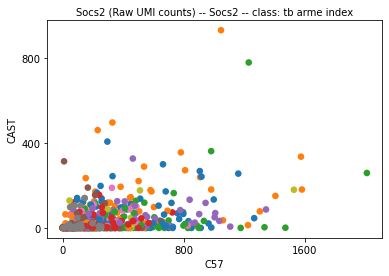

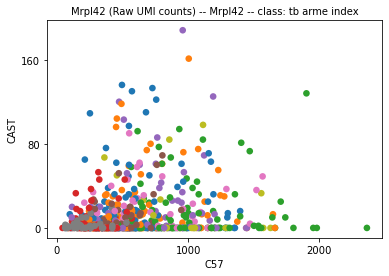

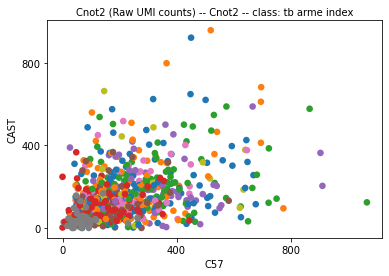

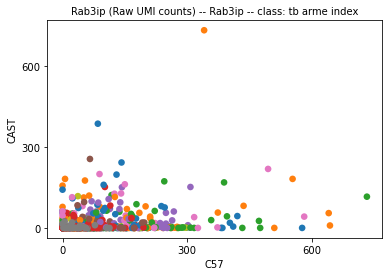

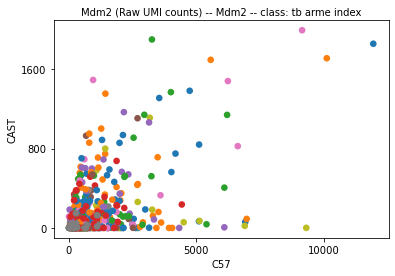

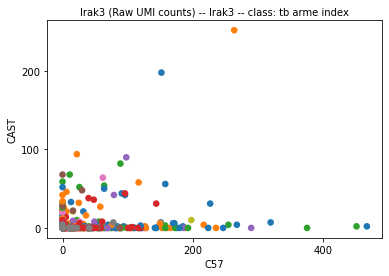

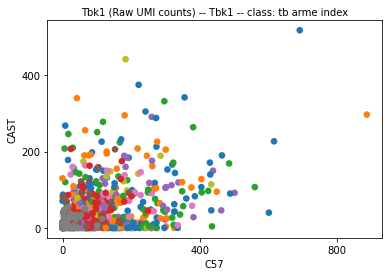

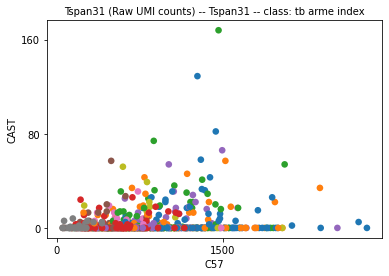

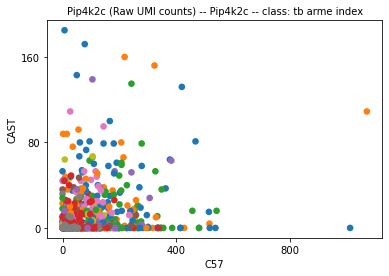

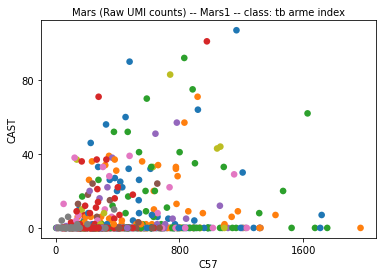

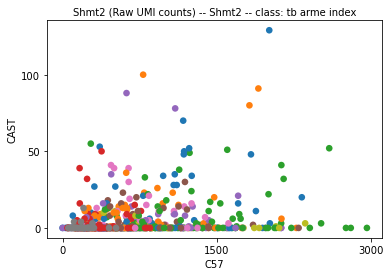

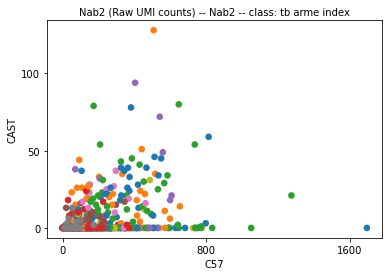

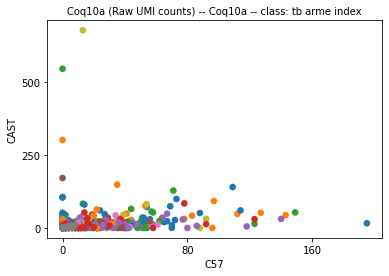

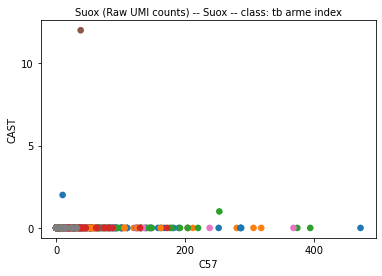

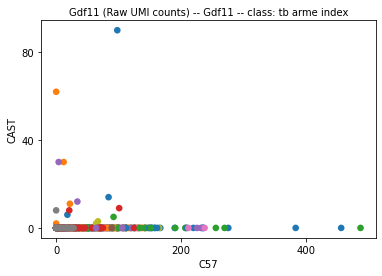

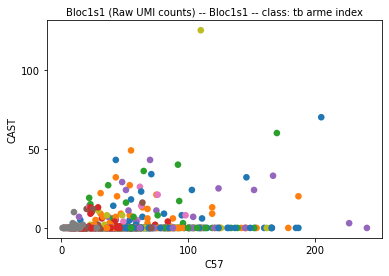

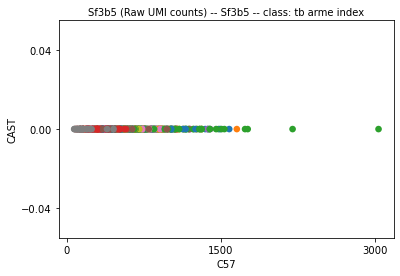

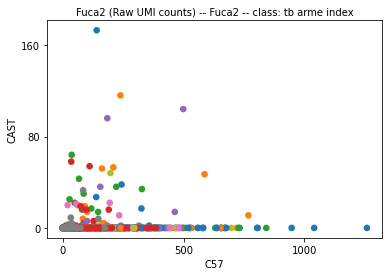

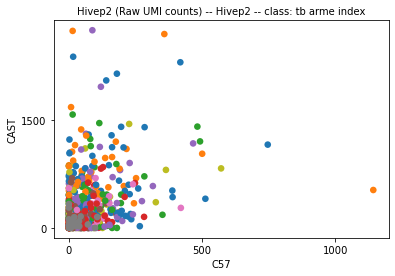

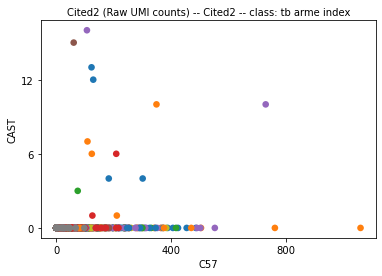

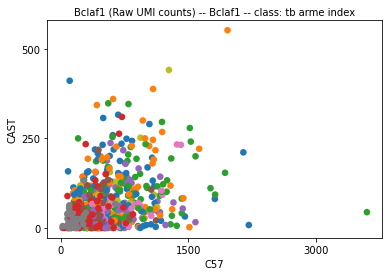

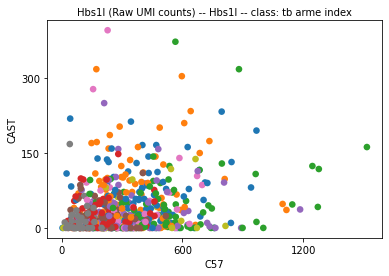

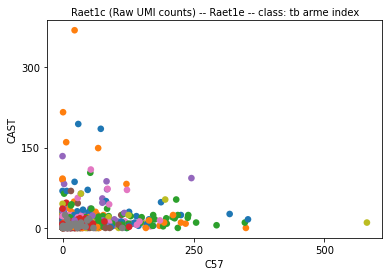

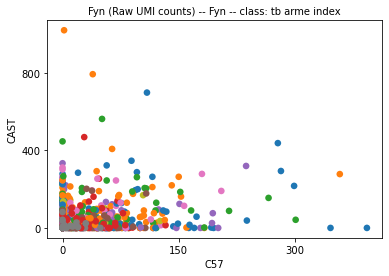

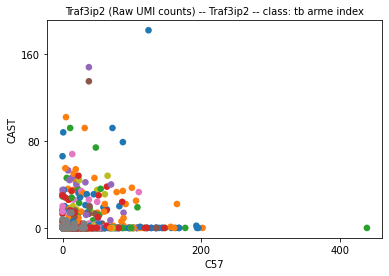

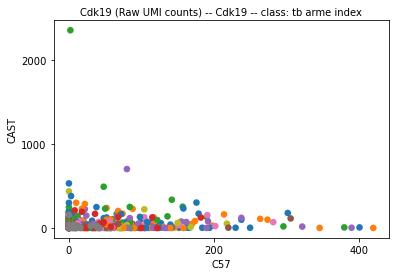

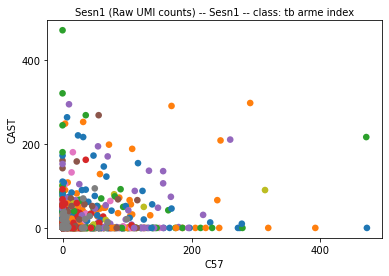

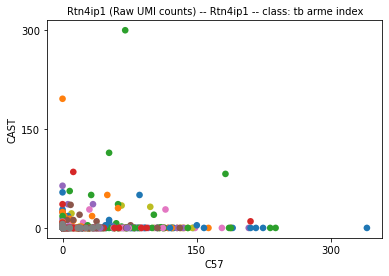

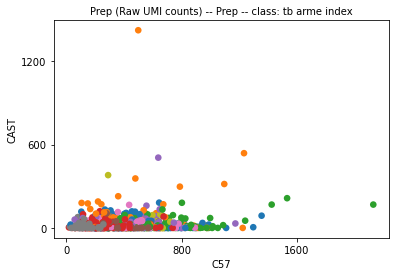

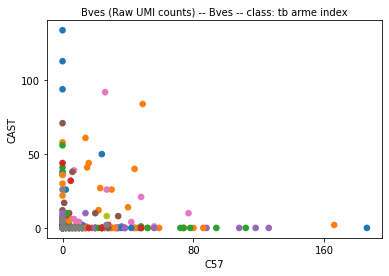

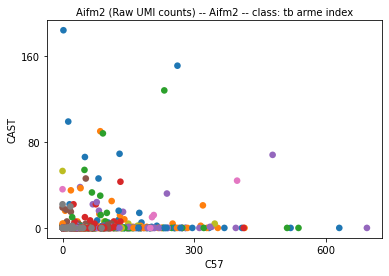

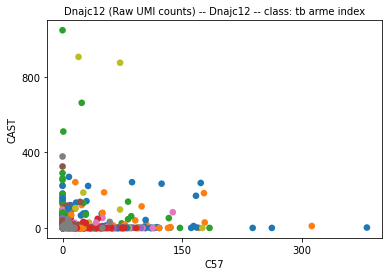

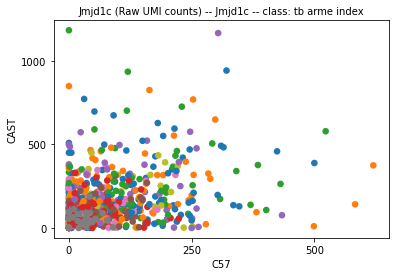

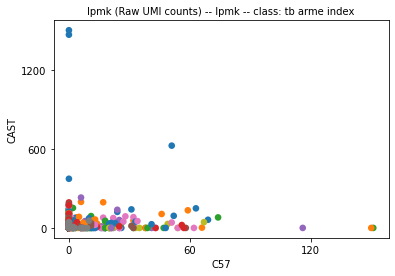

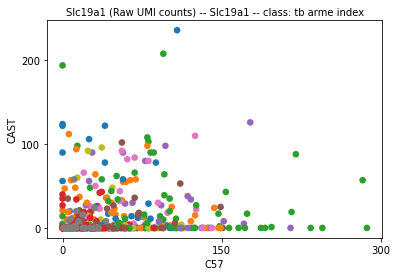

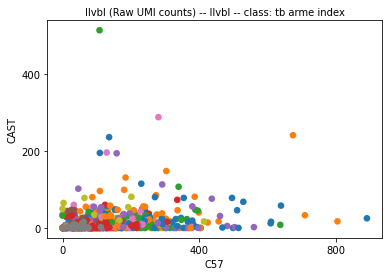

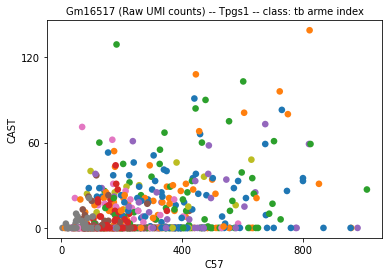

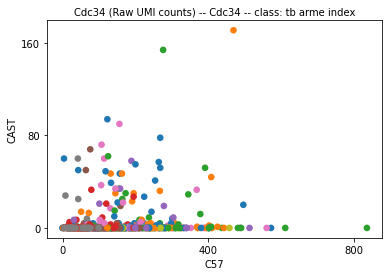

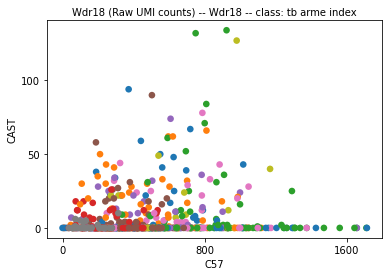

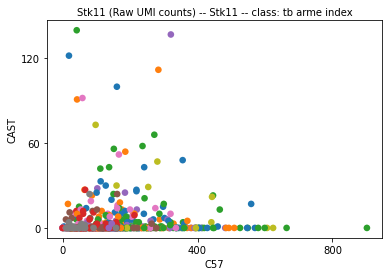

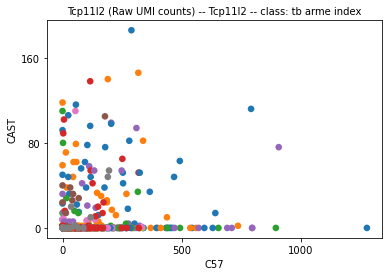

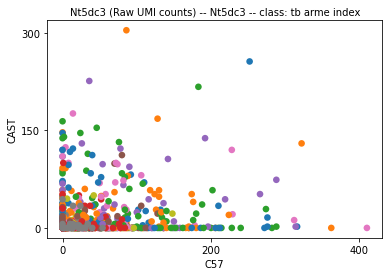

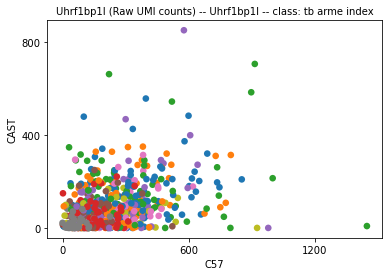

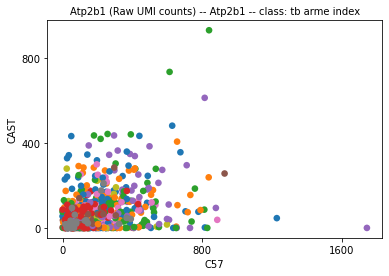

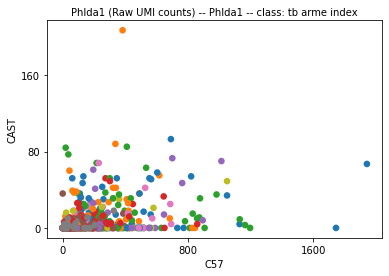

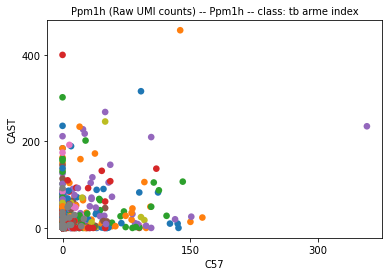

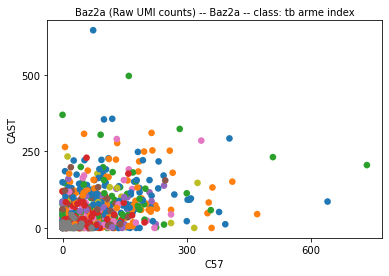

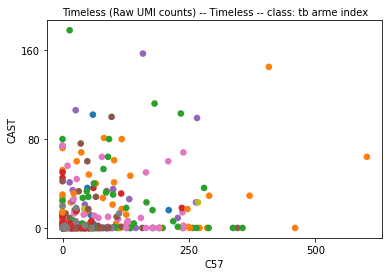

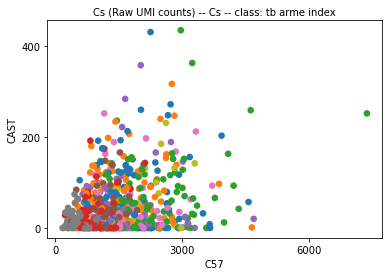

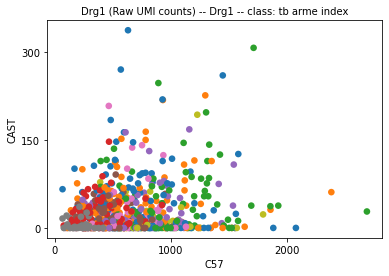

KeyboardInterrupt: 

In [26]:
# for x in tb_arme_index:
#     scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
#                title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: tb_arme_index")

In [ ]:
label = []
class_name = []
for x in adata.var.index:
    if x in bi_allelic_index:
        label.append(0)
    elif x in parent_of_origin_index:
        label.append(1)
    elif x in biased_index:
        label.append(2)
    elif x in tb_arme_index:
        label.append(3)
    elif x in zero_inflated_index:
        label.append(4)
#     else:
#         label.append(2)
adata.var['class_label'] = label